In [2]:
import warnings
warnings.filterwarnings("ignore")
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import QiskitRuntimeService, Batch, Sampler
from math import *

## Zadanie 1 (1 pkt)
Zaimplementować obwody z zadan obliczeniowych uzywając biblioteki qiskit. Przetestować (można używając narzędzi lokalnych)

![](zad1.png)

In [3]:
qnumber = 2
qc = QuantumCircuit(qnumber)
# Notice the order of the labels is reversed with respect to the qubit index to be applied to. Example label "01" initializes the qubit zero to 1 and qubit one to 0
qc.initialize("00")
qc.ry(qubit=0, theta=2*pi/3)
qc.h(qubit=1)
qc.cx(control_qubit=0, target_qubit=1)
display(qc.draw())

┌──────────────────┐┌──────────┐     
q_0: ┤0                 ├┤ Ry(2π/3) ├──■──
     │  Initialize(0,0) │└──┬───┬───┘┌─┴─┐
q_1: ┤1                 ├───┤ H ├────┤ X ├
     └──────────────────┘   └───┘    └───┘

In [4]:
state = Statevector.from_instruction(qc)
state.draw('latex')

<IPython.core.display.Latex object>

![](zad2.png)

In [5]:
qnumber = 2
qc = QuantumCircuit(qnumber)
qc.initialize("00")
qc.h(qubit=0)
qc.ry(qubit=1, theta=2*atan(1/sqrt(2)))
qc.ch(control_qubit=1, target_qubit=0)
display(qc.draw())

┌──────────────────┐    ┌───┐    ┌───┐
q_0: ┤0                 ├────┤ H ├────┤ H ├
     │  Initialize(0,0) │┌───┴───┴───┐└─┬─┘
q_1: ┤1                 ├┤ Ry(1.231) ├──■──
     └──────────────────┘└───────────┘

In [6]:
state = Statevector.from_instruction(qc)
state.draw('latex')

<IPython.core.display.Latex object>

## Zadanie 2 (1pkt)
Za pomocą wybranego  przez siebie przykładowego obwodu kwantowego  należy  zademonstrować za pomocą qiskita i wyjasnić w jaki sposób otrzymujemy i skąd się biorą różnice pomiędzy
1. dokładnymi, wyliczonymi prawdopodobieństwami 
2. histogramem  otrzymanym przez próbkowanie zgodnie z prawdopodobieństwami otrzymanymi z wybranego symulatora 
3. histogramem z prawdziwego urządzenia kwantowego

In [7]:
qnumber = 3
qc = QuantumCircuit(qnumber)
qc.h(qubit=1)
qc.cx(control_qubit=1, target_qubit=2)
qc.cx(control_qubit=2, target_qubit=0)
display(qc.draw())

┌───┐
q_0: ──────────┤ X ├
     ┌───┐     └─┬─┘
q_1: ┤ H ├──■────┼──
     └───┘┌─┴─┐  │  
q_2: ─────┤ X ├──■──
          └───┘

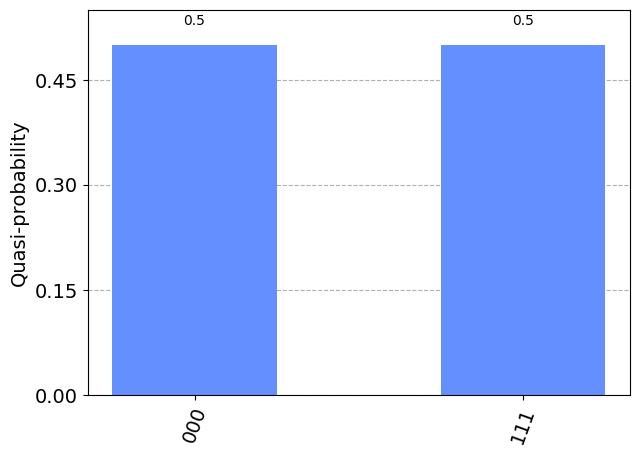

In [8]:
# 1
state = Statevector.from_instruction(qc)
ideal_dist = state.probabilities_dict()
plot_histogram(ideal_dist)

┌───┐ ░ ┌─┐      
   q_0: ──────────┤ X ├─░─┤M├──────
        ┌───┐     └─┬─┘ ░ └╥┘┌─┐   
   q_1: ┤ H ├──■────┼───░──╫─┤M├───
        └───┘┌─┴─┐  │   ░  ║ └╥┘┌─┐
   q_2: ─────┤ X ├──■───░──╫──╫─┤M├
             └───┘      ░  ║  ║ └╥┘
meas: 3/═══════════════════╩══╩══╩═
                           0  1  2

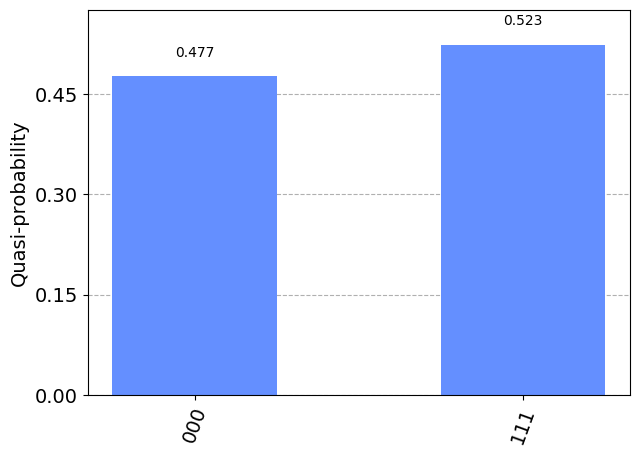

In [9]:
# 2
# dodanie pomiaru
qc.measure_all()
display(qc.draw())

from qiskit.primitives import Sampler as PSampler
results = PSampler().run(qc, shots=1024).result()
sim_dist = results.quasi_dists[0].binary_probabilities()
display(plot_histogram(sim_dist))

In [10]:
#QiskitRuntimeService.save_account(channel='ibm_quantum', instance='ibm-q/open/main', token='mytoken')
service = QiskitRuntimeService()

In [11]:
# wybór prawdziwego urządzenia kwantowego (uwaga: "zjada" minuty - należy monitorować w dashboardzie)
# dostępne urządzenia:
# https://quantum.ibm.com/services/resources?resourceType=systems
backend = service.backend('ibm_osaka')
backend.name

'ibm_osaka'

optimization_level=0:  OrderedDict({'rz': 43, 'sx': 14, 'ecr': 5, 'x': 5, 'measure': 3, 'barrier': 1})


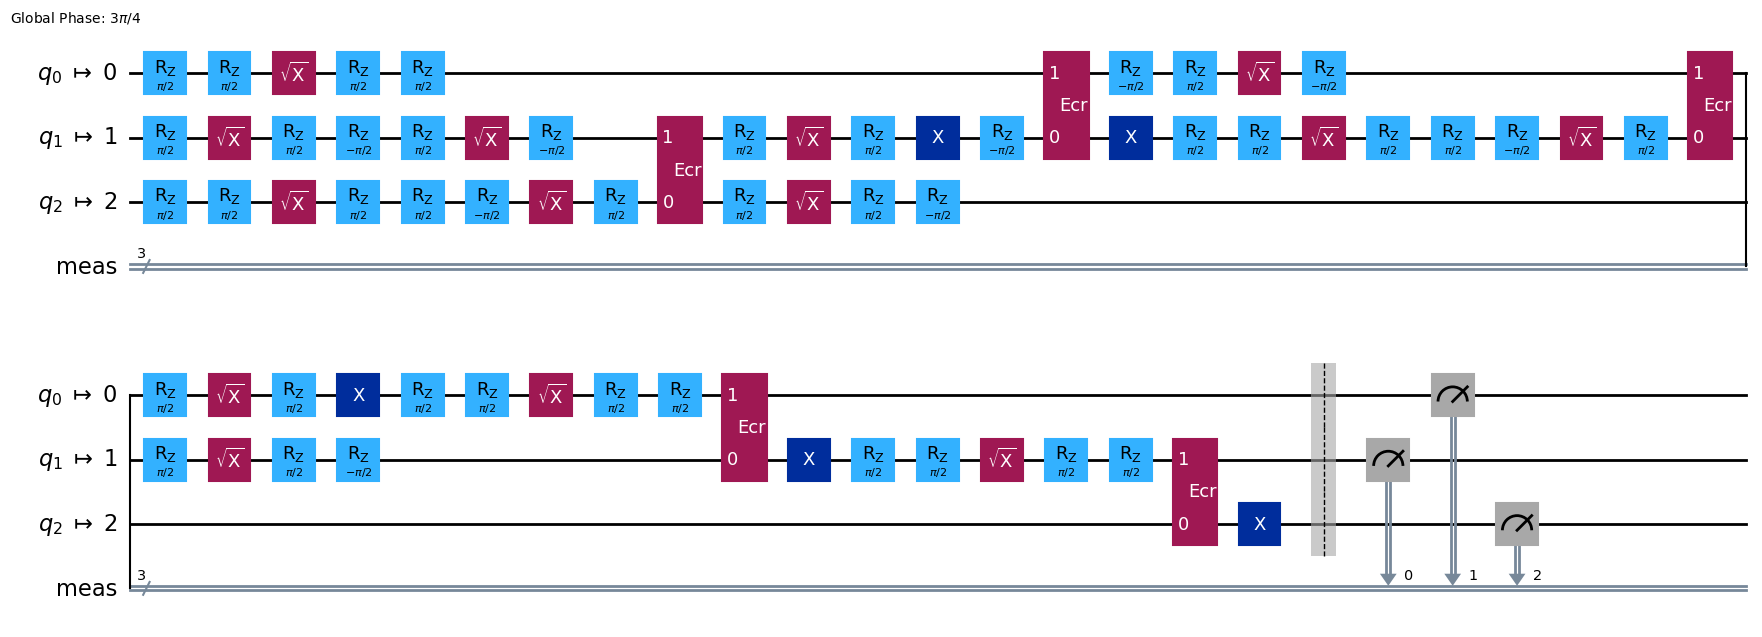

In [12]:
# transpilacja = przetłumaczenie obwodu na bramki wspierane przez urządzenie
# dla ibm_osaka można to sprawdzić tutaj https://quantum.ibm.com/services/resources?system=ibm_osaka
# możliwe jest ustawienie poziomu optymalizacji od 0 do 3
optimization_level = 0
t_qc = transpile(qc, backend, optimization_level=optimization_level, seed_transpiler=0)
print(f"optimization_level={optimization_level}: ", t_qc.count_ops())
t_qc.draw(output="mpl", style="iqp", idle_wires=False)

In [13]:
# uruchomienie - uwaga: podajemy przetranspilowany obwód (t_qc)

# przerwałem wykonanie i pobrałem wynik później
result_dev = service.job('cr1f59x244sg008j7csg').result()

# from qiskit_ibm_runtime import  Batch, Sampler
# with Batch(service=service, backend=backend):
#     sampler = Sampler()
#     job = sampler.run(
#         circuits=[t_qc],
#         shots=100,
#     )
#     result_dev = job.result()

real_dist = result_dev.quasi_dists[0].binary_probabilities()

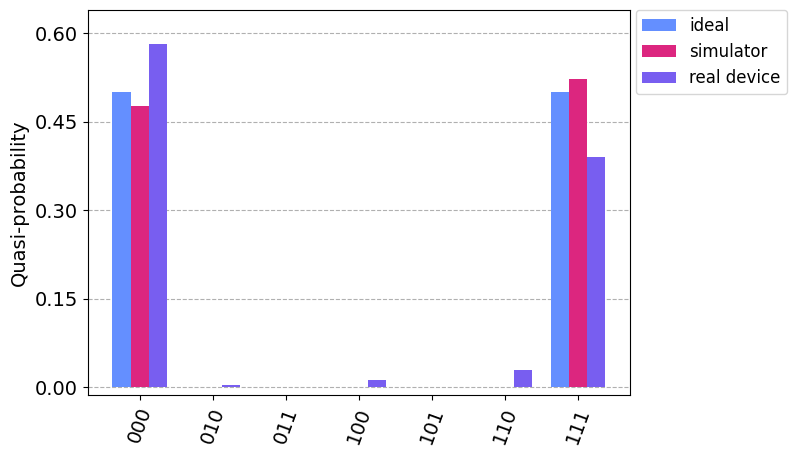

In [14]:
binary_prob = [ideal_dist, sim_dist, real_dist]
plot_histogram(
    binary_prob,
    bar_labels=False,
    legend=[
        "ideal",
        "simulator",
        "real device",
    ],
)

## Zadanie 3 (1pkt)
Zademonstrować przykładową różnicę pomiędzy:
- obwodem użytkownika
- obwodem otrzymanym z transpilera dla wybranego urządzenia kwantowego

- różnice w użytych bramkach - urządzenia mają konkretne bramki więc trzeba dokonać transpilacji, która zamieni bramki w układzie wejściowym na odpowiedniki, które posiada ([SX](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.SXGate), [X](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.XGate), [ECR](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.ECRGate), [RZ](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.RZGate))
- transpilacja ma również poziom optymalizacji, który wpływa na złożoność wyjściowego układu

In [18]:
qnumber = 3
qc = QuantumCircuit(qnumber)
qc.h(qubit=1)
qc.cx(control_qubit=1, target_qubit=2)
qc.cx(control_qubit=2, target_qubit=0)
qc.measure_all()
display(qc.draw())

┌───┐ ░ ┌─┐      
   q_0: ──────────┤ X ├─░─┤M├──────
        ┌───┐     └─┬─┘ ░ └╥┘┌─┐   
   q_1: ┤ H ├──■────┼───░──╫─┤M├───
        └───┘┌─┴─┐  │   ░  ║ └╥┘┌─┐
   q_2: ─────┤ X ├──■───░──╫──╫─┤M├
             └───┘      ░  ║  ║ └╥┘
meas: 3/═══════════════════╩══╩══╩═
                           0  1  2

optimization_level=0:  OrderedDict({'rz': 43, 'sx': 14, 'ecr': 5, 'x': 5, 'measure': 3, 'barrier': 1})


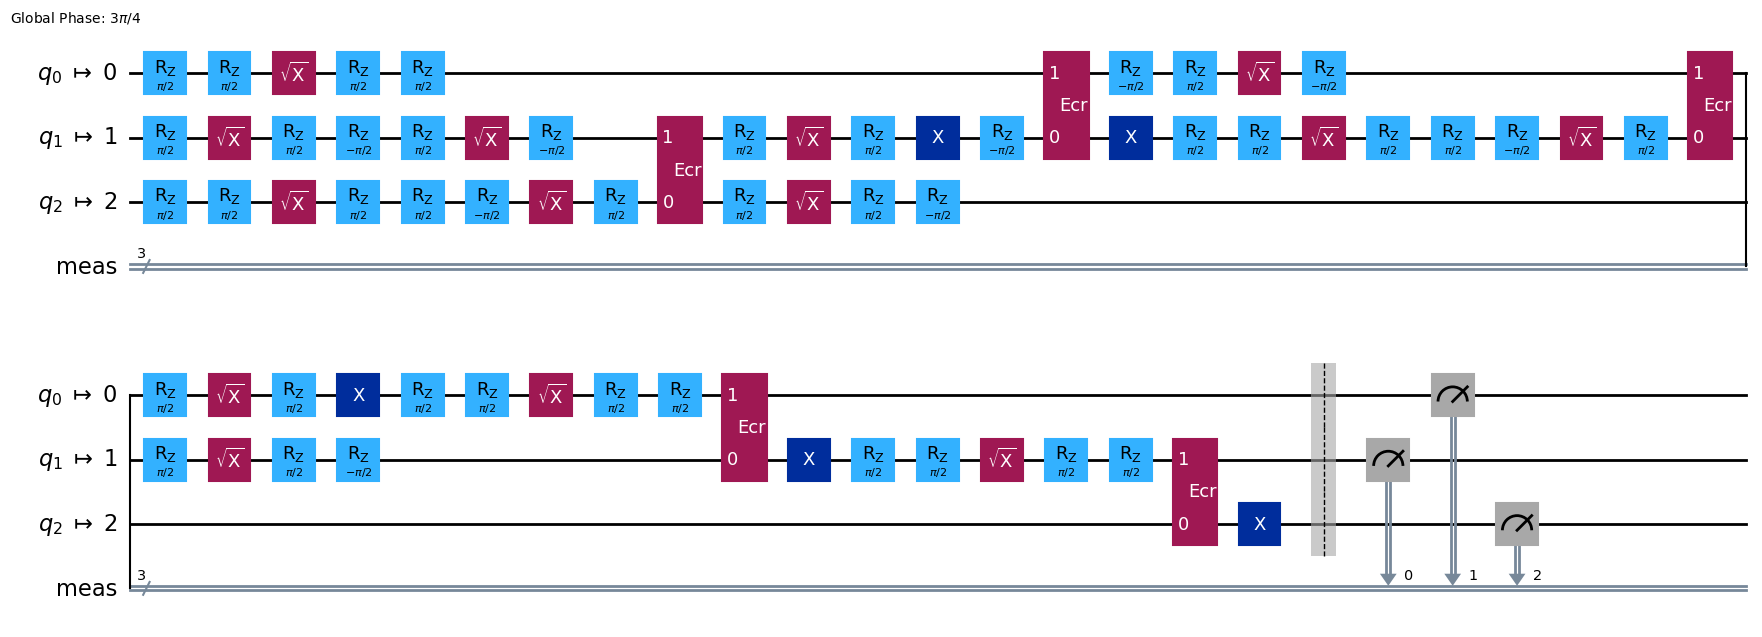

In [19]:
optimization_level = 0
t_qc = transpile(qc, backend, optimization_level=optimization_level, seed_transpiler=0)
print(f"optimization_level={optimization_level}: ", t_qc.count_ops())
t_qc.draw(output="mpl", style="iqp", idle_wires=False)

optimization_level=3:  OrderedDict({'rz': 16, 'sx': 9, 'measure': 3, 'ecr': 2, 'barrier': 1})


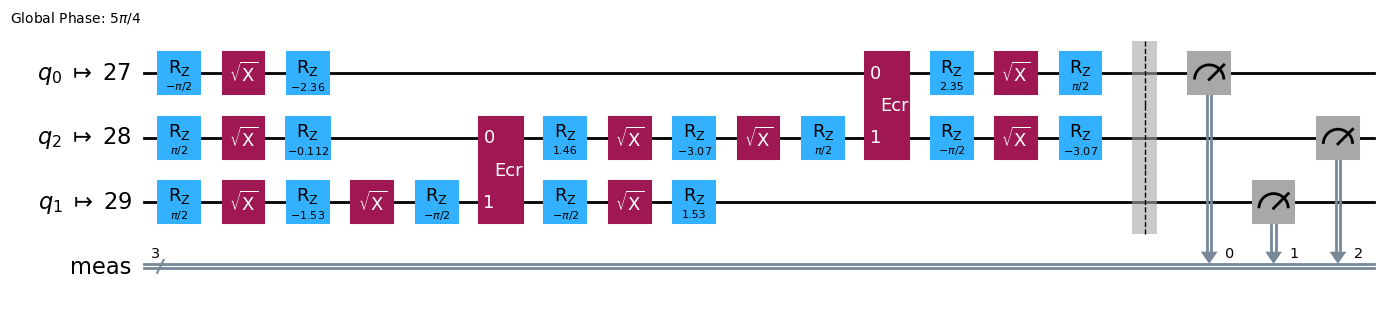

In [20]:
optimization_level = 3
t_qc = transpile(qc, backend, optimization_level=optimization_level, seed_transpiler=0)
print(f"optimization_level={optimization_level}: ", t_qc.count_ops())
t_qc.draw(output="mpl", style="iqp", idle_wires=False)